In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

here = "/project/vitelli/dsseara/schelling/jcolen/sociohydro/nonlinear_simulations"
os.chdir(here)

cuda:0


## Data processing

100%|██████████| 121/121 [00:33<00:00,  3.63it/s]


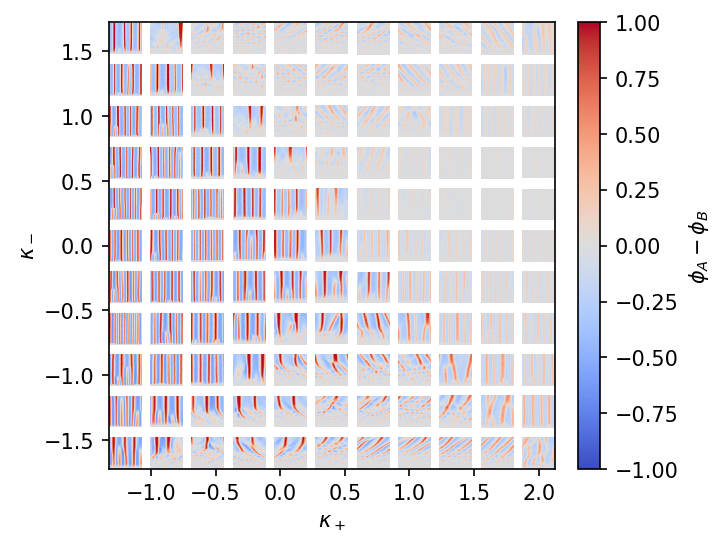

In [13]:
from tqdm import tqdm
from glob import glob
import json


# data_dir = '/home/jcolen/data/sociohydro/2024-03-26_MCPhaseDiagram/data'
data_dir = "/project2/vitelli/dsseara/schelling/2024-03-26_MCPhaseDiagram/data"
folders = sorted(glob(f'{data_dir}/*'))

fig, ax = plt.subplots(dpi=150, figsize=(5, 5), tight_layout=True)

for folder in tqdm(folders):
    data_file = glob(os.path.join(folder, "*hdf5"))
    param_file = glob(os.path.join(folder, "*json"))
    with open(param_file[0]) as pfile:
        p = json.load(pfile)
    x = np.arange(p["grid_size"])
    with h5py.File(data_file[0]) as d:
        ϕA = np.zeros((len(d.keys()), p["grid_size"]))
        ϕB = np.zeros((len(d.keys()), p["grid_size"]))
        t = np.zeros(len(d.keys()))
        for kidx, key in enumerate(d.keys()):
            ϕA[kidx] = d[key]["state"][0, :]
            ϕB[kidx] = d[key]["state"][1, :]
            t[kidx] = d[key]["sweep"][()]
    ϕA /= p["capacity"]
    ϕB /= p["capacity"]
    t *= p["dt"]
    
    Dp = p["kappa_plus"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2 - p["temperature"] * p["fill"][0]
    Dm = p["kappa_minus"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2
    
    a = ax.pcolormesh(
        # Dp + (x-x.max()/2) * 3e-4,
        # Dm + (t-t.max()/2) * 4e-6,
        p["kappa_plus"] + (x-x.max()/2) * 4*10**(-3),
        p["kappa_minus"] + (t-t.max()/2) * 5*10**(-5),
        ϕA - ϕB,
        cmap="coolwarm", vmin=-1, vmax=1,
        rasterized=True)


ax.set(
    # xticks=[-0.1, 0, 0.1], yticks=[-0.1, 0, 0.1],
    xlabel=r"$\kappa_+$", ylabel=r"$\kappa_-$")
ax.set_box_aspect(1)
cax = ax.inset_axes([1.05, 0.0, 0.05, 1])
cbar = fig.colorbar(a, cax=cax, ax=ax)
cbar.ax.set(ylabel=r"$\phi_A - \phi_B$")

plt.show()

if input() == "save":
    fig.savefig("Figures/phase_diagram_kappa.pdf", bbox_inches="tight")

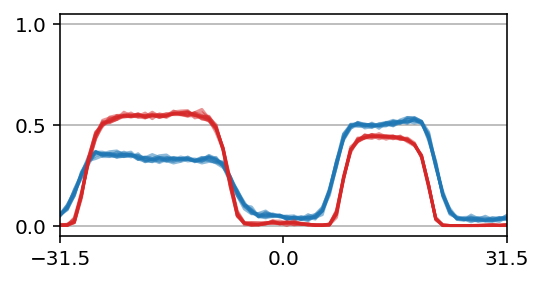

In [3]:
fig, ax = plt.subplots(dpi=144, figsize=(4, 2))
ax.plot(x-x.max()/2, ϕA[-10:-1].T, color="C0", alpha=0.5)
ax.plot(x-x.max()/2, ϕB[-10:-1].T, color="C3", alpha=0.5)
ax.set(ylim=[-0.05, 1.05], yticks=[0, 0.5, 1],
       xlim=[-x.max()/2, x.max()/2], xticks=[-x.max()/2, 0, x.max()/2])
ax.grid(axis="y")

In [4]:
Dm_array = np.zeros(len(folders))
Dp_array = np.zeros(len(folders))

for fidx, folder in enumerate(tqdm(folders)):
    data_file = glob(os.path.join(folder, "*hdf5"))
    param_file = glob(os.path.join(folder, "*json"))
    with open(param_file[0]) as pfile:
        p = json.load(pfile)
    x = np.arange(p["grid_size"])
    
    Dp_array[fidx] = p["kappa_plus"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2 - p["temperature"] * p["fill"][0]
    Dm_array[fidx] = p["kappa_minus"] * p["fill"][0] * (1 - 2 * p["fill"][0]) / 2

100%|██████████| 121/121 [00:00<00:00, 1530.40it/s]


In [5]:
seg_idx = np.logical_and(Dm_array > Dp_array, Dm_array < -Dp_array)
int_idx = np.logical_and(Dm_array < Dp_array, Dm_array > -Dp_array)
mig1_idx = np.logical_and(Dm_array < Dp_array, Dm_array < -Dp_array)
mig2_idx = np.logical_and(Dm_array > Dp_array, Dm_array > -Dp_array)

dynamic_type = np.empty(len(folders), dtype=object)
dynamic_type[seg_idx] = "segregated"
dynamic_type[int_idx] = "integrated"
dynamic_type[mig1_idx] = "migration1"
dynamic_type[mig2_idx] = "migration2"

In [7]:
dynamic_keys = np.array([(f, d) for f,d in zip(folders, dynamic_type)])
np.savetxt(f"{data_dir}/../dynamic_keys.csv", dynamic_keys, delimiter=",", header="file,dynamic_type", fmt="%s,%s", comments="#")

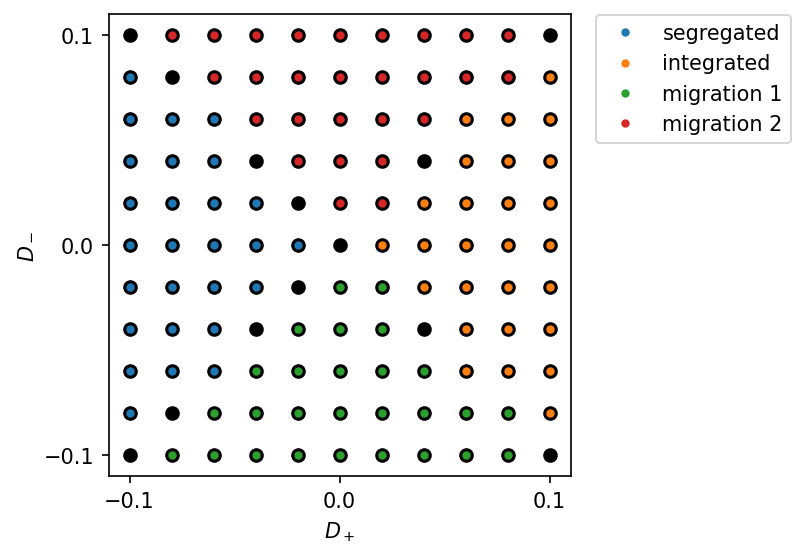

In [8]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 4))
ax.plot(Dp_array, Dm_array, "ko")
ax.plot(Dp_array[seg_idx], Dm_array[seg_idx], ".", label="segregated")
ax.plot(Dp_array[int_idx], Dm_array[int_idx], ".", label="integrated")
ax.plot(Dp_array[mig1_idx], Dm_array[mig1_idx], ".", label="migration 1")
ax.plot(Dp_array[mig2_idx], Dm_array[mig2_idx], ".", label="migration 2")

ax.set(xlabel=r"$D_+$", ylabel=r"$D_-$",
       xticks=[-0.1, 0, 0.1], yticks=[-0.1, 0, 0.1])

ax.set_aspect(1)
ax.legend(loc="center right", bbox_to_anchor=[1.5, 0.86])
# plt.tight_layout()
#fig.savefig("2024-02-14_phaseDefinitions.pdf", bbox_inches="tight")

# Simulating a trained model

## Segregated

Predicting using validation folder km-0.00_kp-0.56
0.0 4880.0 (489,)
Loaded state dict from file


<Figure size 640x480 with 0 Axes>

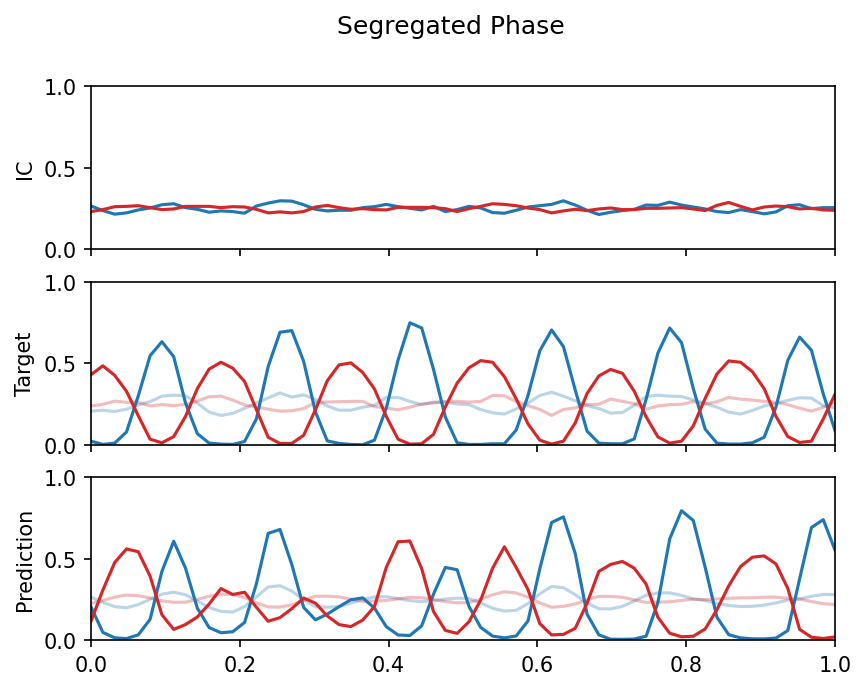

In [6]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting

device = torch.device('cuda:0')

model_path = 'models/SimulationForecasting_segregated_0'
data_dir = "/project2/vitelli/dsseara/schelling/2024-03-26_MCPhaseDiagram/data"

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
#pprint(info)
#folder = np.random.choice(info['val_folder'])
folder = info['val_folder'][1]
print(f'Predicting using validation folder {os.path.basename(folder)}')
datafolder = os.path.join(data_dir, os.path.basename(folder))
ds = SimulationDataset(datafolder, seq_len=50)

# Load model
info = torch.load(f'{model_path}.ckpt')
model = SimulationForecasting().to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

sample = ds[3]

fig, ax = plt.subplots(3, 1, dpi=150, sharex=True, sharey=True)

ax[0].plot(ds.x, sample['ab'][0,0], color='C0')
ax[0].plot(ds.x, sample['ab'][0,1], color='C3')
ax[0].set_ylabel('IC')

ax[1].plot(ds.x, sample['ab'][5,0], color='C0', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][5,1], color='C3', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][40,0], color='C0')
ax[1].plot(ds.x, sample['ab'][40,1], color='C3')
ax[1].set_ylabel('Target')

ab1 = model.simulate(sample['ab'][0:1].to(device), ds.seq_len)[0]
ab1 = ab1.detach().cpu().numpy()

ax[2].plot(ds.x, ab1[5,0], color='C0', alpha=0.3)
ax[2].plot(ds.x, ab1[5,1], color='C3', alpha=0.3)
ax[2].plot(ds.x, ab1[40,0], color='C0')
ax[2].plot(ds.x, ab1[40,1], color='C3')
ax[2].set_ylabel('Prediction')

ax[0].set(xlim=[0,1], ylim=[0,1])

fig.suptitle('Segregated Phase')
if input() == "save":
    plt.savefig('Figures/Segregated.pdf', bbox_inches='tight')

plt.show()

## Integrated

Predicting using validation folder km-0.00_kp1.04
0.0 4850.0 (486,)
Loaded state dict from file


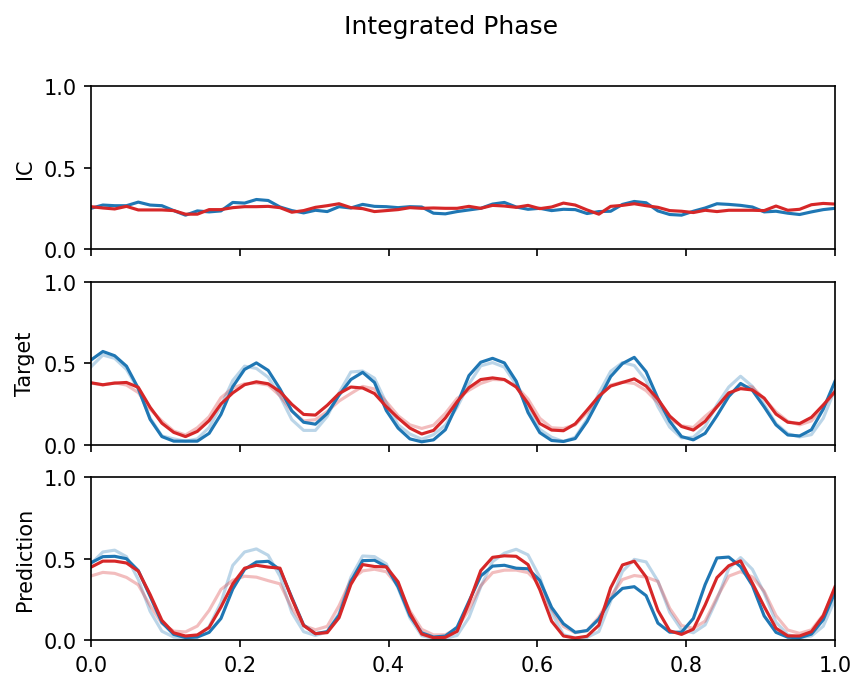

In [7]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting

device = torch.device('cuda:0')

model_path = 'models/SimulationForecasting_integrated_1'

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
#pprint(info)
folder = info['val_folder'][1]
print(f'Predicting using validation folder {os.path.basename(folder)}')
datafolder = os.path.join(data_dir, os.path.basename(folder))
ds = SimulationDataset(datafolder, seq_len=90)

# Load model
info = torch.load(f'{model_path}.ckpt')
model = SimulationForecasting().to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

sample = ds[5]

fig, ax = plt.subplots(3, 1, dpi=150, sharex=True, sharey=True)

ax[0].plot(ds.x, sample['ab'][0,0], color='C0')
ax[0].plot(ds.x, sample['ab'][0,1], color='C3')
ax[0].set_ylabel('IC')

ax[1].plot(ds.x, sample['ab'][40,0], color='C0', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][40,1], color='C3', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][80,0], color='C0')
ax[1].plot(ds.x, sample['ab'][80,1], color='C3')
ax[1].set_ylabel('Target')

ab1 = model.simulate(sample['ab'][0:1].to(device), ds.seq_len)[0]
ab1 = ab1.detach().cpu().numpy()

ax[2].plot(ds.x, ab1[40,0], color='C0', alpha=0.3)
ax[2].plot(ds.x, ab1[40,1], color='C3', alpha=0.3)
ax[2].plot(ds.x, ab1[80,0], color='C0')
ax[2].plot(ds.x, ab1[80,1], color='C3')
ax[2].set_ylabel('Prediction')

ax[0].set(xlim=[0,1], ylim=[0,1])


fig.suptitle('Integrated Phase')

if input() == "save":
    plt.savefig('Figures/Integrated.pdf', bbox_inches='tight')

plt.show()

## Migration 1

Predicting using validation folder km-0.64_kp0.72
0.0 4910.0 (492,)
Loaded state dict from file


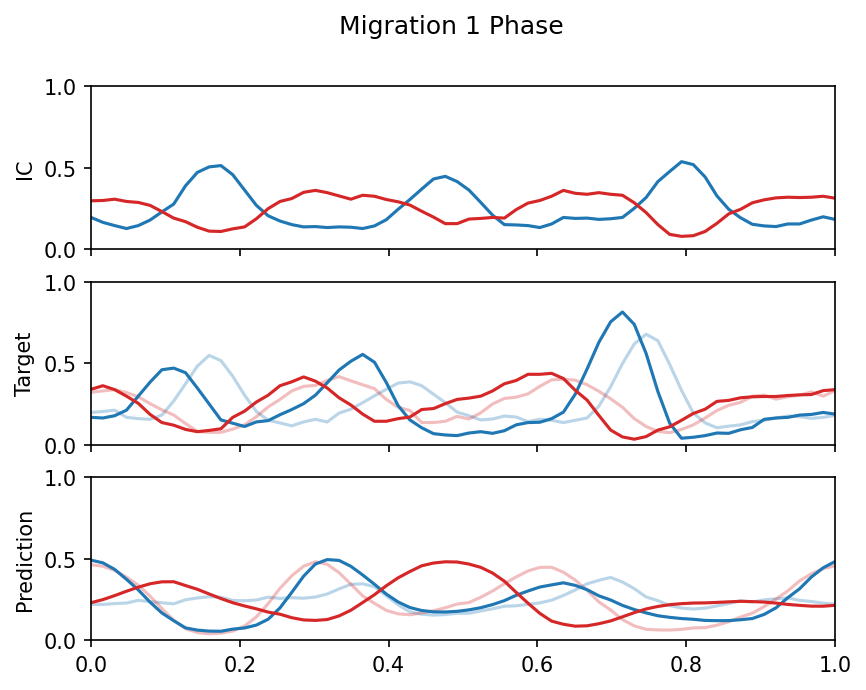

In [8]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting

device = torch.device('cuda:0')

model_path = 'models/SimulationForecasting_migration1_2'

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
#pprint(info)
folder = info['val_folder'][2]
print(f'Predicting using validation folder {os.path.basename(folder)}')
datafolder = os.path.join(data_dir, os.path.basename(folder))
ds = SimulationDataset(datafolder, seq_len=90, tmax=500)

# Load model
info = torch.load(f'{model_path}.ckpt')
model = SimulationForecasting().to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

sample = ds[10]
sample = ds[150]

fig, ax = plt.subplots(3, 1, dpi=150, sharex=True, sharey=True)

ax[0].plot(ds.x, sample['ab'][0,0], color='C0')
ax[0].plot(ds.x, sample['ab'][0,1], color='C3')
ax[0].set_ylabel('IC')

ax[1].plot(ds.x, sample['ab'][40,0], color='C0', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][40,1], color='C3', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][80,0], color='C0')
ax[1].plot(ds.x, sample['ab'][80,1], color='C3')
ax[1].set_ylabel('Target')

ab1 = model.simulate(sample['ab'][0:1].to(device), ds.seq_len)[0]
ab1 = ab1.detach().cpu().numpy()

ax[2].plot(ds.x, ab1[40,0], color='C0', alpha=0.3)
ax[2].plot(ds.x, ab1[40,1], color='C3', alpha=0.3)
ax[2].plot(ds.x, ab1[80,0], color='C0')
ax[2].plot(ds.x, ab1[80,1], color='C3')
ax[2].set_ylabel('Prediction')

ax[0].set(xlim=[0,1], ylim=[0,1])


fig.suptitle('Migration 1 Phase')

if input() == "save":
    plt.savefig('Figures/Migration1.pdf', bbox_inches='tight')

plt.show()

## Migration 2

Predicting using validation folder km0.64_kp0.08
0.0 4930.0 (494,)
Loaded state dict from file


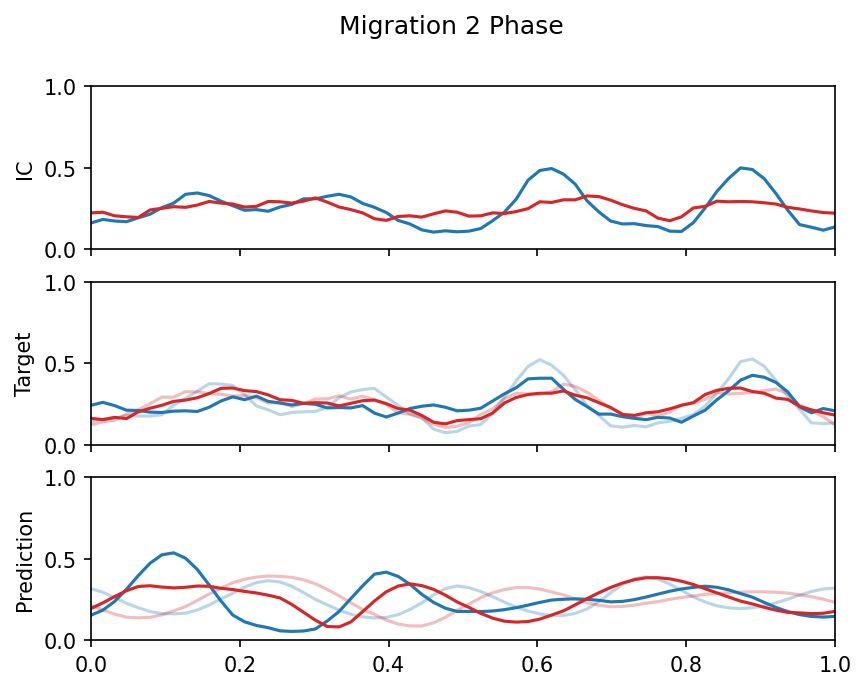

In [9]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting

device = torch.device('cuda:0')

model_path = 'models/SimulationForecasting_migration2_3'

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
#pprint(info)
folder = info['val_folder'][2]
print(f'Predicting using validation folder {os.path.basename(folder)}')
datafolder = os.path.join(data_dir, os.path.basename(folder))
ds = SimulationDataset(datafolder, seq_len=90, tmax=500)

# Load model
info = torch.load(f'{model_path}.ckpt')
model = SimulationForecasting().to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

sample = ds[10]
sample = ds[150]

fig, ax = plt.subplots(3, 1, dpi=150, sharex=True, sharey=True)

ax[0].plot(ds.x, sample['ab'][0,0], color='C0')
ax[0].plot(ds.x, sample['ab'][0,1], color='C3')
ax[0].set_ylabel('IC')

ax[1].plot(ds.x, sample['ab'][40,0], color='C0', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][40,1], color='C3', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][80,0], color='C0')
ax[1].plot(ds.x, sample['ab'][80,1], color='C3')
ax[1].set_ylabel('Target')

ab1 = model.simulate(sample['ab'][0:1].to(device), ds.seq_len)[0]
ab1 = ab1.detach().cpu().numpy()

ax[2].plot(ds.x, ab1[40,0], color='C0', alpha=0.3)
ax[2].plot(ds.x, ab1[40,1], color='C3', alpha=0.3)
ax[2].plot(ds.x, ab1[80,0], color='C0')
ax[2].plot(ds.x, ab1[80,1], color='C3')
ax[2].set_ylabel('Prediction')

ax[0].set(xlim=[0,1], ylim=[0,1])


fig.suptitle('Migration 2 Phase')

if input() == "save":
    plt.savefig('Figures/Migration2.pdf', bbox_inches='tight')

plt.show()

In [6]:
info = pd.read_csv('/home/jcolen/data/sociohydro/2024-03-26_MCPhaseDiagram/dynamic_keys.csv')
info.groupby('dynamic_type').count()

,#file
dynamic_type,
integrated,27
migration1,27
migration2,27
segregated,27
